# RAG (Retrieval-Augmented Generation) Demo

This notebook demonstrates building a complete RAG system using LangChain, Chroma vector database, and LangGraph. The implementation showcases how to:

- **Set up environment configuration** with type-safe settings management
- **Create a vector store** with OpenAI embeddings and persistent Chroma storage
- **Build an intelligent agent** using LangGraph state machines for retrieval and generation
- **Test the system** with real queries to demonstrate end-to-end functionality

The RAG agent can answer questions by first retrieving relevant documents from the vector store, then generating informed responses based on the retrieved context using GPT-4o-mini.

## Prerequisites
- OpenAI API key set in environment variables
- Install dependencies: `uv sync`

Setting up environment configuration and validating required environment variables.

This cell:
- **Defines configuration schema**: Creates a `Settings` class using Pydantic settings for type-safe environment variable management
- **Validates required variables**: Ensures `OPENAI_API_KEY` is present in the environment (required for OpenAI API access)
- **Instantiates settings**: Creates a global `settings` object that automatically loads and validates environment variables

The configuration will raise an error if the required `OPENAI_API_KEY` environment variable is missing, ensuring proper API authentication is set up before proceeding

In [1]:
from pydantic_settings import BaseSettings, SettingsConfigDict


class Settings(BaseSettings):
    model_config = SettingsConfigDict(extra="ignore", env_file=".env")

    openai_api_key: str
    database_host: str = "localhost"
    database_port: int = 8000


settings = Settings()

Setting up embeddings and vector store with sample documents.

This cell:
- Creates OpenAI embeddings using the text-embedding-3-small model
- Initializes a Chroma vector store with persistent storage
- Adds sample documents about LangChain, RAG, and FAISS to the vector store
- Stores the documents with unique IDs for later retrieval

In [2]:
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

print(f"Vector store connection: {settings.database_host=}; {settings.database_port=}")

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma(
    collection_name="docs",
    embedding_function=embeddings,
    host=settings.database_host,
    port=settings.database_port
)
documents = [
    Document(
        page_content="LangChain is a framework for building applications with LLMs.",
        id="1",
    ),
    Document(page_content="RAG stands for Retrieval-Augmented Generation.", id="2"),
    Document(
        page_content="FAISS is Facebook AI Similarity Search for vector indexing.",
        id="3",
    ),
]
ids = list(map(lambda doc: doc.id, documents))
_ = vector_store.add_documents(documents=documents, ids=ids)

Vector store connection: settings.database_host='vector_store'; settings.database_port=8000


Building a RAG (Retrieval-Augmented Generation) agent with LangGraph.

This cell:
- **Defines state management**: Creates `GraphState` and `GraphConfig` classes to manage conversation flow
- **Initializes the chat model**: Sets up GPT-4o-mini as the main language model agent
- **Creates retrieval tool**: Implements a `retrieve` function that searches the vector store for relevant documents
- **Builds the agent workflow**: Constructs a LangGraph state machine with nodes for:
  - `entry_node`: Starting point for the conversation
  - `query_or_respond`: Determines if retrieval is needed or responds directly
  - `tools`: Executes the retrieval tool when needed
  - `generate`: Creates final responses using retrieved context
  - `finish_node`: Completion point
- **Sets up conditional flow**: Uses `tools_condition` to decide whether to retrieve documents or end the conversation
- **Compiles and visualizes**: Creates the executable graph and displays its structure as a Mermaid diagram

The resulting agent can answer questions by first retrieving relevant documents from the vector store, then generating informed responses based on the

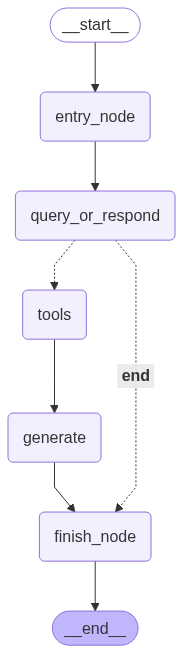

In [3]:
import textwrap
from typing import TypedDict

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.tools import tool
from langgraph.graph import END
from langgraph.graph.state import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel


class GraphConfig(TypedDict): ...


class GraphState(BaseModel):
    messages: list[AnyMessage]

    @property
    def has_no_messages(self) -> bool:
        return len(self.messages) == 0

    def with_message_added(self, message: AnyMessage) -> "GraphState":
        self.messages.append(message)

        return self


rag_agent = init_chat_model("gpt-4o-mini", model_provider="openai")


@tool(response_format="content_and_artifact")
def retrieve(query: str) -> tuple[str, list[Document]]:
    """Retrieve information related to a query."""

    print("Invoked 'retrieve' tool")
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs


tools = ToolNode([retrieve])


def entry_node(state: GraphState) -> GraphState:
    return state


async def query_or_respond(state: GraphState) -> GraphState:
    if state.has_no_messages:
        return state

    llm_with_tools = rag_agent.bind_tools([retrieve])
    try:
        response = await llm_with_tools.ainvoke(state.messages)
    except Exception:
        return state

    return state.with_message_added(response)


async def generate(state: GraphState) -> GraphState:
    recent_tool_messages: list[ToolMessage] = []
    for message in reversed(state.messages):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break

    assert len(recent_tool_messages) > 0, (
        "The `tools_condition` should have gated this node from getting triggered"
    )

    tool_messages = recent_tool_messages[::-1]
    docs_content: str = "\n\n".join(map(lambda doc: doc.content, tool_messages))
    system_message_content = textwrap.dedent(f"""
    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question.
    If you don't know the answer, say that you don't know.
    Use three sentences maximum and keep the answer concise.

    {docs_content}
    """).strip()
    conversation_messages = list(
        filter(
            lambda message: message.type in ("human", "system")
            or (message.type == "ai" and len(message.tool_calls) == 0),
            state.messages,
        )
    )
    prompt_messages = [SystemMessage(system_message_content)] + conversation_messages
    try:
        response = await rag_agent.ainvoke(prompt_messages)
    except Exception:
        return state

    return state.with_message_added(response)


def finish_node(state: GraphState) -> GraphState:
    return state


graph = (
    StateGraph(GraphState, config_schema=GraphConfig)
    .add_node(entry_node)
    .add_node(tools)
    .add_node(query_or_respond)
    .add_node(generate)
    .add_node(finish_node)
    .set_entry_point("entry_node")
    .add_edge("entry_node", "query_or_respond")
    .add_conditional_edges(
        "query_or_respond", tools_condition, {END: "finish_node", "tools": "tools"}
    )
    .add_edge("tools", "generate")
    .add_edge("generate", "finish_node")
    .set_finish_point("finish_node")
    .compile()
)


async def invoke_graph(state: GraphState, config: GraphConfig) -> GraphState:
    end_state = await graph.ainvoke(input=state, config=config)
    validated_end_state = GraphState(**end_state)

    return validated_end_state


async def ask_rag_agent(question: str) -> str:
    messages = [HumanMessage(content=question)]
    new_state = await invoke_graph(state=GraphState(messages=messages), config={})

    assert len(new_state.messages) >= len(messages)

    if len(new_state.messages) == len(messages):
        answer = "Failed to get response from Agent"
    else:
        answer = new_state.messages[-1].content

    assert isinstance(answer, str)

    return answer


display(Image(graph.get_graph().draw_mermaid_png()))

Testing the RAG agent with a sample question.

This cell:
- **Creates a test message**: Constructs a `HumanMessage` asking "What is RAG?"
- **Invokes the agent**: Calls the `invoke_graph` function with the test message to run the complete RAG workflow
- **Validates the response**: Checks that the agent successfully generated a response by comparing message counts
- **Extracts the answer**: Retrieves the final response content from the last message in the conversation
- **Displays the result**: Shows the agent's answer to demonstrate the RAG system in action

This demonstrates the complete RAG pipeline: the agent will retrieve relevant documents about RAG from the vector store and generate an informed response based on

In [4]:
await ask_rag_agent(question="What is RAG?")

Invoked 'retrieve' tool


'RAG stands for Retrieval-Augmented Generation. LangChain is a framework for building applications with large language models (LLMs).'